**Project**

# Character recognition in natural images

*Author: Łukasz Dzwoniarek*

**Problem**

Recognizing different characters on pictures.
- latin (lowercase and uppercase)
- digits


**The approach**

Using algorithms such as:
- Machine Learning
    - k-Nearest Neighbors
- Neural Networks
    - Residual Nets


**The idea**

k-Nearest Neighbors has been selected as initial method for data classification as it achived 2.9% error rate with hand-written digits. However when used with new data set (comparable number of samples, but six times as many classes) algorithm failed to produce satisfactory results despite a few modifications.

![picture](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)


Residual Nets have been used as last chance solution to dataset classification. It achieved ten times lower error rate on this problem than kNN on hand written digits. To make this approach fisabble on a thousands items dataset a pre-trained model has been used (on set of 1.2 million images with 1000 classes). 

![picture](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)


**Results**

Mathod name | Error rate
--- | ---
kNN basic | 51.2 %
kNN with masks | 61.5 %
kNN with dual data | 45.7 %
kNN with adaptive masks | 54.9 %
kNN with adaptive masks and dual data | 51.7 %
kNN with edge detection | 64.2 %
ResNet-34 | 41.8 %
ResNet-34 with unfreezing | 23.2 %
ResNet-34 with fine-tuning | 22.8 %
ResNet-50 | 36.0 %


**kNN** 

Dificulty with this method is fact that kNN compares tables (representing photos) and same backgrount "color" (actualy shade, becouse we use monochrome) have a big imact o distance beetwen data points.


**kNN with masks** 

As compared with normal kNN results are even worst, due to the fact that mask simply replaces part of the image with "0". This but a big bias (when computing distance for kNN) on mask shape, not te actual image content. 


**kNN with adaptive masks** 

Improves result only compared with mask, but not the base line. Replacing masked part of image by avrage value from image proved to be semi-usefull solution.  


**kNN with dual data** 

Doubling size of of data by inverting all data impoves error rate but only by small factor.


**kNN with adaptive masks and dual data** 

Better compared than masks, but still worse result tah simple double data.


**kNN with edge detection** 

Worse result that base line, whith is a suprising result compared with result achived during Assigment1


**ResNet-34**

Pre-trained neural networks proved to be solution to classification problem. 


**ResNet-34 with unfreezing**

Training all layers of Neural Network helped improve results, as only last layers. Hoever this type of training takes more time. 


**ResNet-34 with fine-tuning**

Fine tuning learing rates of each layer helped improve result, but only a small fratction after many tries with difrent rates. 

**ResNet-50**

Training takes twice as long compared with ResNet32. Error rate is slighlt lower, but better results with less time and memory are achivables with ResNet-32 and fine-tuning. 



**Next steps**

- normalize pictures prior to procesing (orientation)
- generate better masks
- double check data set for miss-classification of pictures

**Runing notebook**

Notebook is bug free, so it can be run as is (as long as databse link is falid).


To execte notebook in minutes, rather than hours plese change settings:

Runtime / Change runtime type / Hardware Acceleration / GPU

## Problems
- distinguishes similar characters: 
    - o, O, 0
    - i, I, 1
- tendency to over-label I (upper case i) in edge detection mode
- some miss-labled examples in data sate (at least two found), but effect of these on error rate is a few times lower than random selection of train and test set

## Credits and Acknowledgements:
- Jan Chorowski - kNN
    https://github.com/janchorowski/ml_uwr/blob/fall2019/assignment1/Assignment1.ipynb
- Salim Chemlal - Artificial neural networks
    https://github.com/SalChem/Fastai-iNotes-iTutorials/blob/master/Image_Recognition_Basics.ipynb
- T. E. de Campos, B. R. Babu and M. Varma -  Character recognition in natural images / Data set
http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/
- philtrade - methods description
https://docs.fast.ai/
- Wikipedia - inustrations
https://en.wikipedia.org/wiki/Convolutional_neural_network

# Data set

### The Chars74K dataset

In the English language, Latin script (excluding accents) and Hindu-Arabic numerals are used. Our dataset consists of:

- classes: 0-9, A-Z, a-z
- 7705 characters obtained from natural images

This data diversity provides challenge for clasification algorythmes.

![picture](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/Samples/confusing_english.png)


# Importing data

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.

!pip install -q gdown httpimport

![ -e EnglishImg.tgz ] || gdown 'http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz' -O EnglishImg.tgz
# ![ -e EnglishImg.tgz ] || wget -O EnglishImg.tgz "https://uniwroc-my.sharepoint.com/:u:/g/personal/274404_uwr_edu_pl/Ef-ZQOpAtwRAvF3NjoWPPn0BdJ5bVm5ItD7YBfxHuvOWlA?e=KrpN8D&download=1"


In [0]:
# Standard IPython notebook imports
%matplotlib inline

import os

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import scipy.stats as sstats

import seaborn as sns
from sklearn import datasets

from PIL import Image

from random import shuffle, Random

import scipy as sp
from skimage.morphology import closing
import imageio


# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')

In [191]:
# check data content
!ls -lh

total 129M
drwxr-xr-x 3 root   root  4.0K Feb 24 06:30 English
-rw-r--r-- 1 root   root  128M Feb 23 09:22 EnglishImg.tgz
drwxr-xr-x 3 root   root  248K Feb 24 06:37 EnglishNames
-rwxr-xr-x 1 170994 13010  34K Aug 14  2009 n_error.png
-rwxr-xr-x 1 170994 13010  239 Aug 14  2009 n_msk_error.png
drwxr-xr-x 1 root   root  4.0K Feb  5 18:37 sample_data
-rwxr-xr-x 1 170994 13010  12K Aug 14  2009 t_error.png
-rwxr-xr-x 1 170994 13010  269 Aug 14  2009 t_msk_error.png


In [0]:
# !rm -r English
# !rm t_error.png

In [0]:
# unzip data
![ -e English ] || tar zxvf EnglishImg.tgz

In [194]:
# check data content
!ls
# !ls English/Img/GoodImg/Bmp/Sample001

English		EnglishNames  n_msk_error.png  t_error.png
EnglishImg.tgz	n_error.png   sample_data      t_msk_error.png


# Load dataset

In [0]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        new_img = img.resize((28,28)).convert('L')
        np_img = np.array(new_img)
        images.append(np_img)
    return images

def load_folders_from_folder(folder):
    images = []
    filenames = os.listdir(folder)
    filenames.sort()
    for filename in filenames:
        images.append(load_images_from_folder(os.path.join(folder,filename)))
    return images

In [0]:
images = load_folders_from_folder('English/Img/GoodImg/Bmp/')


In [0]:
def get_labels():
    numbers = [i for i in range(10)] 
    uppercase = [chr(i) for i in range(ord('A'), ord('Z')+1)]
    lowercase = [chr(i) for i in range(ord('a'), ord('z')+1)]

    return numbers + uppercase + lowercase

In [198]:
labels = get_labels()

print( labels )
print( len(labels) )
print( len(images) )

print( [len(i) for i in images] )
print( sum([len(i) for i in images]) )
list_labels = [[labels[i]] * len(images[i]) for i in range(len(labels))]
print( [[labels[i]] * len(images[i]) for i in range(len(labels))] )
print( sum([len([labels[i]] * len(images[i])) for i in range(len(labels))]) )


flat_list_images = [item for sublist in images for item in sublist]
flat_list_labels = [item for sublist in list_labels for item in sublist]

print( len(flat_list_images) )
print( len(flat_list_labels) )



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
62
62
[105, 79, 70, 50, 47, 64, 64, 48, 32, 34, 558, 115, 215, 191, 445, 79, 143, 193, 302, 77, 92, 215, 149, 363, 382, 159, 35, 389, 342, 312, 92, 84, 67, 80, 67, 55, 158, 38, 63, 46, 227, 37, 36, 52, 127, 33, 34, 58, 43, 135, 148, 37, 54, 126, 124, 110, 41, 33, 36, 35, 43, 35]
7703
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [0]:
def shuffle_two(list_a, list_b):
    combined = list(zip(list_a, list_b))
    Random(4).shuffle(combined)#, lambda: .5)
    new_a = [i for (i,_) in combined]
    new_b = [i for (_,i) in combined]
    return new_a, new_b

def shuffle_three(list_a, list_b, list_c):
    combined = list(zip(list_a, list_b, list_c))
    shuffle(combined)#, lambda: .5)
    new_a = [i for (i,_,_) in combined]
    new_b = [i for (_,i,_) in combined]
    new_c = [i for (_,_,i) in combined]
    return new_a, new_b, new_c

In [0]:
# shuffle data
flat_list_images, flat_list_labels = shuffle_two(flat_list_images, flat_list_labels)

In [0]:
# Split train data into train and validation sets
flat_list_images = np.asarray(flat_list_images)
flat_list_labels = np.asarray(flat_list_labels)

test = int(flat_list_images.shape[0]*0.9)
valid = int(flat_list_images.shape[0]*0.8)

mnist_full_train_data_uint8 = flat_list_images[:test]
mnist_full_train_labels_int64 = flat_list_labels[:test]
mnist_test_data_uint8 = flat_list_images[test:]
mnist_test_labels_int64 = flat_list_labels[test:]

mnist_train_data_uint8 = mnist_full_train_data_uint8[:valid]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:valid]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[valid:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[valid:]

In [202]:
print( type(mnist_train_data_uint8) )
print( mnist_train_data_uint8.shape )
print( type(mnist_train_data_uint8[1]) )
print( mnist_train_data_uint8[1].shape )
print( mnist_train_data_uint8[100].shape )

<class 'numpy.ndarray'>
(6162, 28, 28)
<class 'numpy.ndarray'>
(28, 28)
(28, 28)


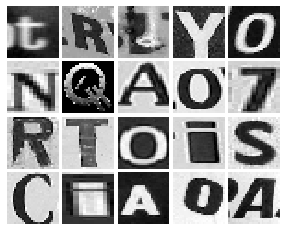

In [203]:
plot_mat(mnist_train_data_uint8[:20, None], cmap='gray')

In [204]:
mnist_full_train_labels_int64[:20]

array(['t', 'R', 'I', 'Y', 'o', 'N', 'Q', 'A', 'O', '7', 'R', 'T', 'o', 'i', 'S', 'C', 'i', 'A', '0', 'A'], dtype='<U1')

## Fix dataset

Data set contains mislabled picture that is labeled as 't', but is 'c':

'English/Img/GoodImg/Bmp/Sample056/img056-00029.png'

It is removed to better evaluate methonds.

In [0]:
![ -e 't_msk_error.png' ] || mv 'English/Img/GoodImg/Msk/Sample056/img056-00029.png' 't_msk_error.png'
![ -e 't_error.png' ] || mv 'English/Img/GoodImg/Bmp/Sample056/img056-00029.png' 't_error.png'

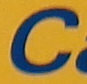

In [206]:
Image.open('t_error.png')

As we can see bellow 56 group contains letter 't':

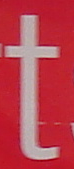

In [207]:
Image.open('English/Img/GoodImg/Bmp/Sample056/img056-00030.png')

In [0]:
![ -e 'n_msk_error.png' ] || mv 'English/Img/GoodImg/Msk/Sample015/img015-00028.png' 'n_msk_error.png'
![ -e 'n_error.png' ] || mv 'English/Img/GoodImg/Bmp/Sample015/img015-00028.png' 'n_error.png'

As we can see bellow 56 group contains letter 'E':

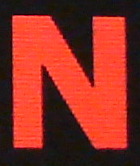

In [209]:
Image.open('n_error.png')


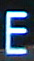

In [210]:
Image.open('English/Img/GoodImg/Bmp/Sample015/img015-00030.png')

# kNN implementation

In [0]:
# MNIST is large.
# Implement a batched KNN classifier, which processes the test data in small batches
# and returns the error rates

def batched_KNN(train_X, train_Y, test_X, ks, verbose=False, batch_size=200):
    all_preds = {k: [] for k in ks}
    for i in range(0, test_X.shape[0], batch_size):
        batch_X = test_X[i:i + batch_size]
        if verbose:
            print(f"Processing batch {i}:{i + batch_X.shape[0]}... ", end='')

            preds = KNN(train_X, train_Y, batch_X, ks, verbose)
            for k in all_preds.keys():
                all_preds[k] = np.concatenate((all_preds[k], preds[k]))
    return all_preds

In [0]:
def KNN(train_X, train_Y, test_X, ks, verbose=False):
    """
    Compute predictions for various k
    Args:
        train_X: array of shape Ntrain x D
        train_Y: array of shape Ntrain
        test_X: array of shape Ntest x D
        ks: list of integers
    Returns:
        preds: dict k: predictions for k
    """
    # Cats data to float32
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)

    # Alloc space for results
    preds = {}

    if verbose:
        print("Computing distances... ", end='')

    distans = np.sqrt(
        -2*train_X.dot(test_X.T) 
        + (train_X**2).sum(axis=1).reshape(-1,1) 
        + (test_X**2).sum(axis=1).reshape(1,-1)  
        )

    if verbose:
        print("Sorting... ", end='')
    
    closest = distans.argsort(axis=0)

    if verbose:
        print("Computing predictions...", end='')
    
    targets = train_Y[closest]

    for k in ks:
        predictions = sstats.mode(targets[:k], axis=0)[0]

        predictions = predictions.ravel()
        preds[k] = predictions
    if verbose:
        print("Done")
    return preds

In [0]:
def err_rates(preds, test_Y):
    ret = {}
    for k, preds_k in  preds.items():
        ret[k] = np.sum(preds_k != test_Y)/len(preds_k)
    return ret

# Misclassification heatmap

In [0]:
def label_to_number(label):
    labels = get_labels()
    thisdict = dict()
    for i in range(len(labels)):
        thisdict[str(labels[i])] = i
    return thisdict[label]

def test_heatmap(p, l):
    w = np.zeros((62, 62))
    for i in range(len(l)):
        x = label_to_number(p[1][i])
        y = label_to_number(l[i])
        w[x, y] += 1

    w = w / np.maximum(np.sum(w, axis=0), np.ones(62))

    # Create a dataset (fake)
    df = pd.DataFrame(w, index=get_labels(), columns=get_labels())
    
    # Default heatmap: just a visualization of this square matrix
    s = 15
    plt.figure(figsize = (s,s))
    p1 = sns.heatmap(df)
    plt.xlabel("labels")
    plt.ylabel("preds")
    plt.show()


# kNN in use

## kNN basic

In [0]:
images = load_folders_from_folder('English/Img/GoodImg/Bmp/')

labels = get_labels()

list_labels = [[labels[i]] * len(images[i]) for i in range(len(labels))]

flat_list_images = [item for sublist in images for item in sublist]
flat_list_labels = [item for sublist in list_labels for item in sublist]

In [0]:
# shuffle data
flat_list_images, flat_list_labels = shuffle_two(flat_list_images, flat_list_labels)

In [0]:
# Split train data into train and validation sets
flat_list_images = np.asarray(flat_list_images)
flat_list_labels = np.asarray(flat_list_labels)

test = int(flat_list_images.shape[0]*0.9)
valid = int(flat_list_images.shape[0]*0.8)

mnist_full_train_data_uint8 = flat_list_images[:test]
mnist_full_train_labels_int64 = flat_list_labels[:test]
mnist_test_data_uint8 = flat_list_images[test:]
mnist_test_labels_int64 = flat_list_labels[test:]

mnist_train_data_uint8 = mnist_full_train_data_uint8[:valid]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:valid]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[valid:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[valid:]

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:770... Computing distances... Sorting... Computing predictions...Done


Text(0, 0.5, 'error rate')

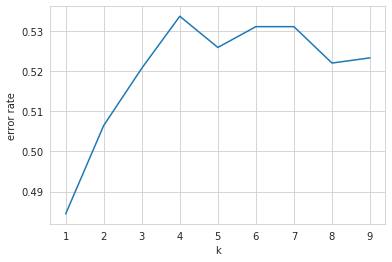

In [222]:
# Now find the best k on the validation set
ks = list(range(1,10))
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, verbose=True)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])
plt.xlabel('k')
plt.ylabel('error rate')

In [223]:
# Now use the best k to compute the test error

best_K = 1

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K], verbose=True)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:771... Computing distances... Sorting... Computing predictions...Done


When k=1 the test error rate is 44.0%%


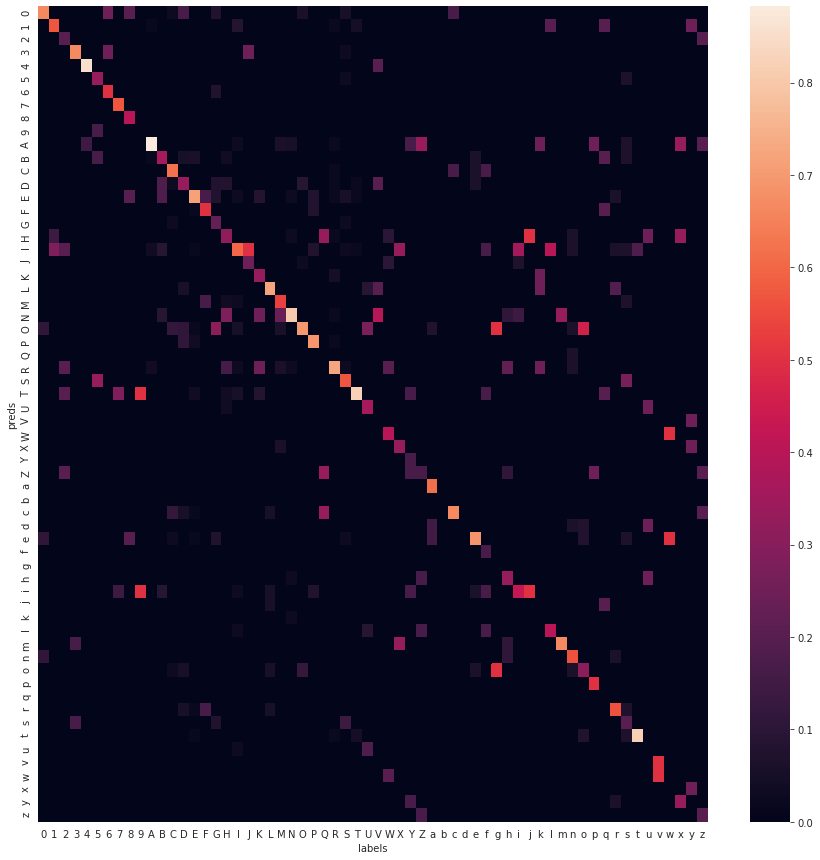

In [224]:
test_heatmap(mnist_test_preds, mnist_test_labels_int64)

## kNN using masks

In [0]:
images = load_folders_from_folder('English/Img/GoodImg/Bmp/')
masks = load_folders_from_folder('English/Img/GoodImg/Msk/')
labels = get_labels()

list_labels = [[labels[i]] * len(images[i]) for i in range(len(labels))]

flat_list_images = [item for sublist in images for item in sublist]
flat_list_labels = [item for sublist in list_labels for item in sublist]
flat_list_masks = [item for sublist in masks for item in sublist]

In [0]:
# shuffle data
flat_list_images, flat_list_labels, flat_list_masks = shuffle_three(flat_list_images, flat_list_labels, flat_list_masks)

In [0]:
# Split train data into train and validation sets
flat_list_images = np.asarray(flat_list_images) * ( np.asarray(flat_list_masks) / 255 )
flat_list_labels = np.asarray(flat_list_labels)

test = int(flat_list_images.shape[0]*0.9)
valid = int(flat_list_images.shape[0]*0.8)

mnist_full_train_data_uint8 = flat_list_images[:test]
mnist_full_train_labels_int64 = flat_list_labels[:test]
mnist_test_data_uint8 = flat_list_images[test:]
mnist_test_labels_int64 = flat_list_labels[test:]

mnist_train_data_uint8 = mnist_full_train_data_uint8[:valid]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:valid]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[valid:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[valid:]

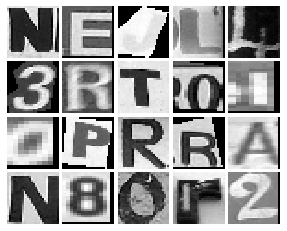

In [228]:
plot_mat(mnist_train_data_uint8[:20, None], cmap='gray')

In [229]:
np.asarray(flat_list_masks[:7000])[0][0]

array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255], dtype=uint8)

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:770... Computing distances... Sorting... Computing predictions...Done


Text(0, 0.5, 'error rate')

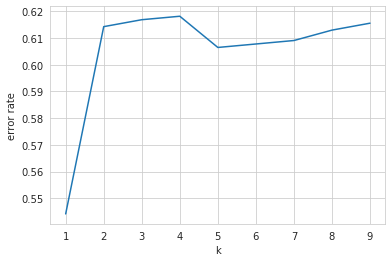

In [230]:
# Now find the best k on the validation set
ks = list(range(1,10))
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, verbose=True)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])
plt.xlabel('k')
plt.ylabel('error rate')

In [231]:
# Now use the best k to compute the test error

best_K = 1

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K], verbose=True)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:771... Computing distances... Sorting... Computing predictions...Done


When k=1 the test error rate is 55.6%%


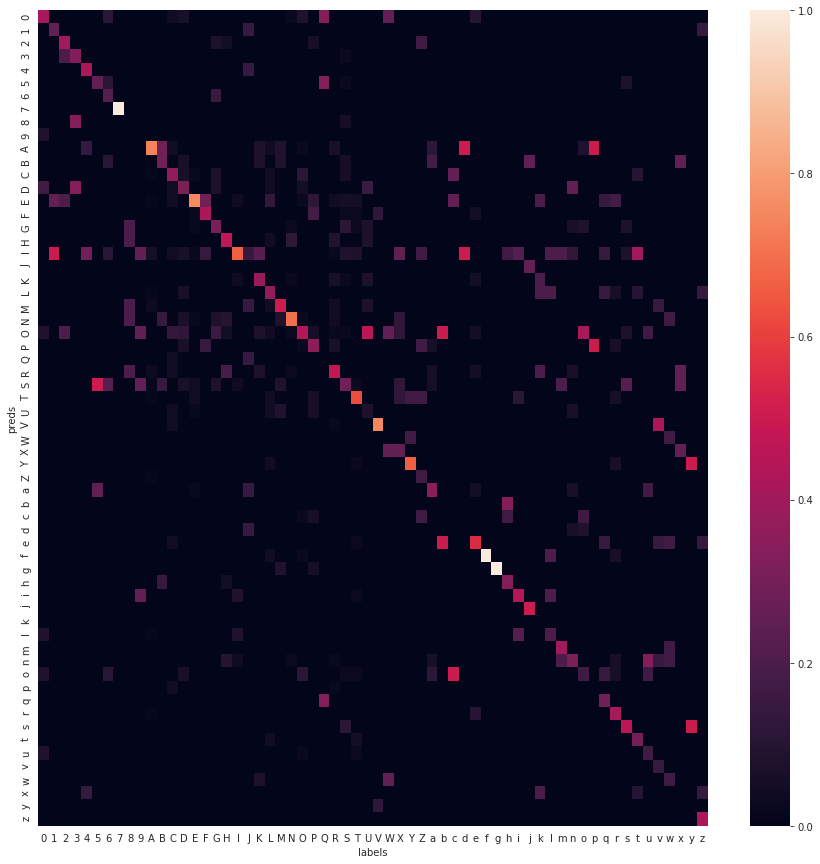

In [232]:
test_heatmap(mnist_test_preds, mnist_test_labels_int64)

## kNN using dual data

In [0]:
images = load_folders_from_folder('English/Img/GoodImg/Bmp/')

labels = get_labels()

list_labels = [[labels[i]] * len(images[i]) for i in range(len(labels))]

flat_list_images = [item for sublist in images for item in sublist]
flat_list_labels = [item for sublist in list_labels for item in sublist]

flat_list_images_inverse = [((image-127.5)*-1)+127.5 for image in flat_list_images]

flat_list_images = flat_list_images + flat_list_images_inverse
flat_list_labels = flat_list_labels + flat_list_labels
flat_list_masks = flat_list_masks + flat_list_masks

In [0]:
# shuffle data
flat_list_images, flat_list_labels = shuffle_two(flat_list_images, flat_list_labels)

In [0]:
# Split train data into train and validation sets
flat_list_images = np.asarray(flat_list_images)
flat_list_labels = np.asarray(flat_list_labels)
test = int(flat_list_images.shape[0]*0.9)
valid = int(flat_list_images.shape[0]*0.8)

mnist_full_train_data_uint8 = flat_list_images[:test]
mnist_full_train_labels_int64 = flat_list_labels[:test]
mnist_test_data_uint8 = flat_list_images[test:]
mnist_test_labels_int64 = flat_list_labels[test:]

mnist_train_data_uint8 = mnist_full_train_data_uint8[:valid]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:valid]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[valid:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[valid:]

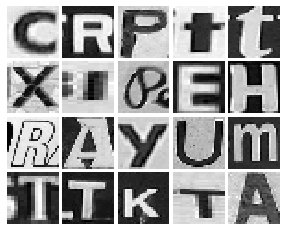

In [236]:
plot_mat(mnist_train_data_uint8[:20, None], cmap='gray')

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:800... Computing distances... Sorting... Computing predictions...Done
Processing batch 800:1000... Computing distances... Sorting... Computing predictions...Done
Processing batch 1000:1200... Computing distances... Sorting... Computing predictions...Done
Processing batch 1200:1400... Computing distances... Sorting... Computing predictions...Done
Processing batch 1400:1541... Computing distances... Sorting... Computing predictions...Done


Text(0, 0.5, 'error rate')

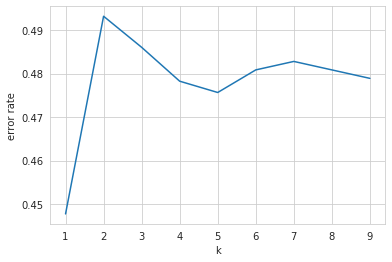

In [238]:
# Now find the best k on the validation set
ks = list(range(1,10))
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, verbose=True)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])
plt.xlabel('k')
plt.ylabel('error rate')

In [239]:
# Now use the best k to compute the test error

best_K = 1

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K], verbose=True)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:800... Computing distances... Sorting... Computing predictions...Done
Processing batch 800:1000... Computing distances... Sorting... Computing predictions...Done
Processing batch 1000:1200... Computing distances... Sorting... Computing predictions...Done
Processing batch 1200:1400... Computing distances... Sorting... Computing predictions...Done
Processing batch 1400:1541... Computing distances... Sorting... Computing predictions...Done


When k=1 the test error rate is 44.3%%


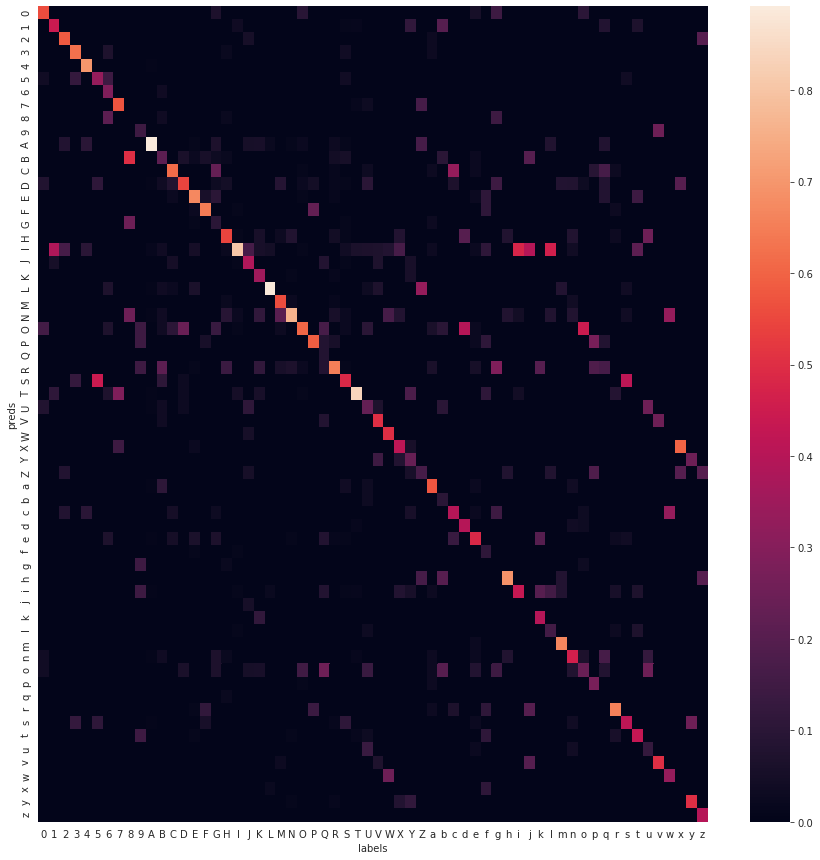

In [240]:
test_heatmap(mnist_test_preds, mnist_test_labels_int64)

## kNN with adaptive masks

In [0]:
images = load_folders_from_folder('English/Img/GoodImg/Bmp/')
masks = load_folders_from_folder('English/Img/GoodImg/Msk/')
labels = get_labels()

list_labels = [[labels[i]] * len(images[i]) for i in range(len(labels))]

flat_list_images = [item for sublist in images for item in sublist]
flat_list_labels = [item for sublist in list_labels for item in sublist]
flat_list_masks = [item for sublist in masks for item in sublist]

In [0]:
# shuffle data
flat_list_images, flat_list_labels = shuffle_two(flat_list_images, flat_list_labels)

In [243]:
new = np.average(flat_list_images, axis=(1,2))
print( new.shape )
print( new[1] )

(7703,)
109.56505102040816


In [0]:
# Split train data into train and validation sets
flat_list_images = np.asarray(flat_list_images)
flat_list_masks = np.asarray(flat_list_masks)
flat_list_labels = np.asarray(flat_list_labels)

test = int(flat_list_images.shape[0]*0.9)
valid = int(flat_list_images.shape[0]*0.8)
samples = flat_list_images.shape[0]

flat_list_clean = flat_list_images * (flat_list_masks / 255)
flat_list_back = np.reshape(((flat_list_masks / 255) - 1), (samples,28*28)) * np.average(flat_list_images, axis=(1,2))[:,None]
flat_list_images = flat_list_clean - np.reshape(flat_list_back, (samples,28,28))

mnist_full_train_data_uint8 = flat_list_images[:test]
mnist_full_train_labels_int64 = flat_list_labels[:test]
mnist_test_data_uint8 = flat_list_images[test:]
mnist_test_labels_int64 = flat_list_labels[test:]

mnist_train_data_uint8 = mnist_full_train_data_uint8[:valid]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:valid]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[valid:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[valid:]

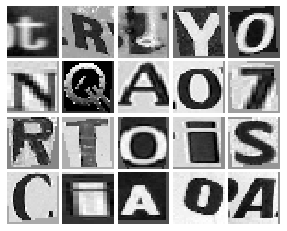

In [245]:
plot_mat(mnist_train_data_uint8[:20, None], cmap='gray')

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:770... Computing distances... Sorting... Computing predictions...Done


Text(0, 0.5, 'error rate')

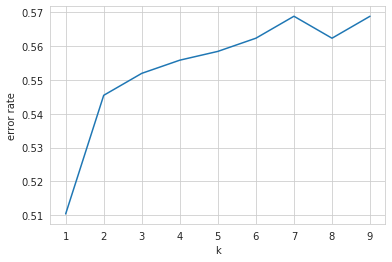

In [246]:
# Now find the best k on the validation set
ks = list(range(1,10))
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, verbose=True)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])
plt.xlabel('k')
plt.ylabel('error rate')

In [247]:
# Now use the best k to compute the test error

best_K = 1

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K], verbose=True)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:771... Computing distances... Sorting... Computing predictions...Done


When k=1 the test error rate is 48.0%%


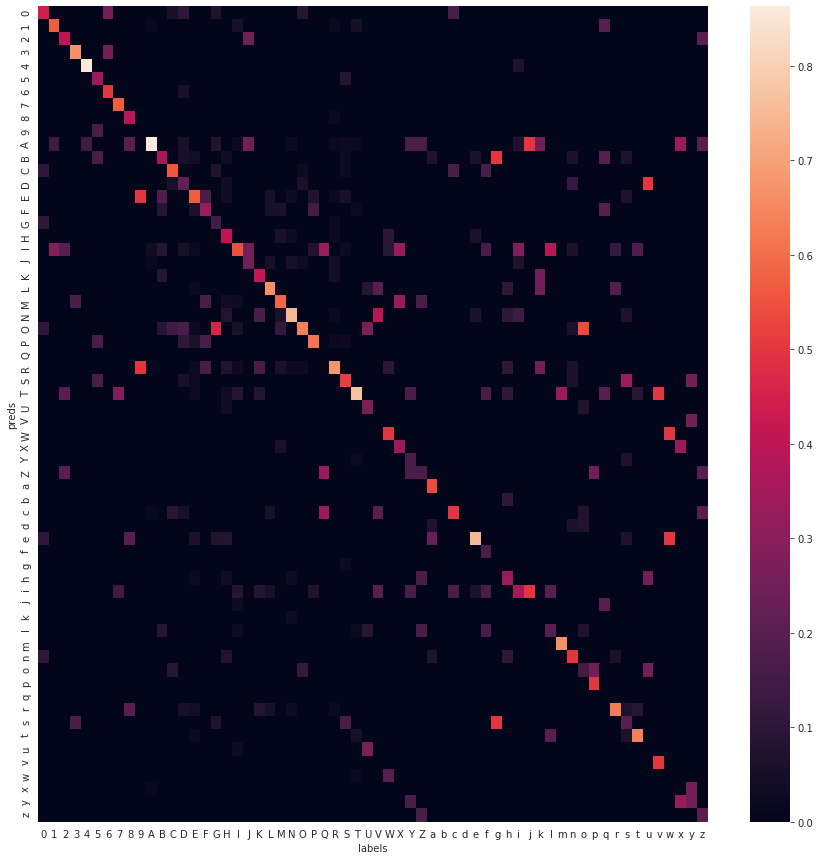

In [248]:
test_heatmap(mnist_test_preds, mnist_test_labels_int64)

## kNN with adaptive masks and dual data

In [0]:
images = load_folders_from_folder('English/Img/GoodImg/Bmp/')
masks = load_folders_from_folder('English/Img/GoodImg/Msk/')
labels = get_labels()

list_labels = [[labels[i]] * len(images[i]) for i in range(len(labels))]

flat_list_images = [item for sublist in images for item in sublist]
flat_list_labels = [item for sublist in list_labels for item in sublist]
flat_list_masks = [item for sublist in masks for item in sublist]

flat_list_images_inverse = [((image-127.5)*-1)+127.5 for image in flat_list_images]

flat_list_images = flat_list_images + flat_list_images_inverse
flat_list_labels = flat_list_labels + flat_list_labels
flat_list_masks = flat_list_masks + flat_list_masks

In [0]:
# shuffle data
flat_list_images, flat_list_labels = shuffle_two(flat_list_images, flat_list_labels)

In [0]:
# Split train data into train and validation sets
flat_list_images = np.asarray(flat_list_images)
flat_list_masks = np.asarray(flat_list_masks)
flat_list_labels = np.asarray(flat_list_labels)

test = int(flat_list_images.shape[0]*0.9)
valid = int(flat_list_images.shape[0]*0.8)
samples = flat_list_images.shape[0]

flat_list_clean = flat_list_images * (flat_list_masks / 255)
flat_list_back = np.reshape(((flat_list_masks / 255) - 1), (samples,28*28)) * np.average(flat_list_images, axis=(1,2))[:,None]
flat_list_images = flat_list_clean - np.reshape(flat_list_back, (samples,28,28))

mnist_full_train_data_uint8 = flat_list_images[:test]
mnist_full_train_labels_int64 = flat_list_labels[:test]
mnist_test_data_uint8 = flat_list_images[test:]
mnist_test_labels_int64 = flat_list_labels[test:]

mnist_train_data_uint8 = mnist_full_train_data_uint8[:valid]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:valid]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[valid:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[valid:]

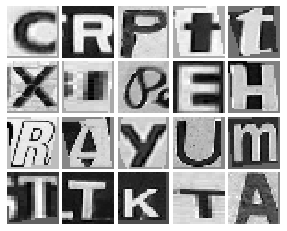

In [252]:
plot_mat(mnist_train_data_uint8[:20, None], cmap='gray')

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:800... Computing distances... Sorting... Computing predictions...Done
Processing batch 800:1000... Computing distances... Sorting... Computing predictions...Done
Processing batch 1000:1200... Computing distances... Sorting... Computing predictions...Done
Processing batch 1200:1400... Computing distances... Sorting... Computing predictions...Done
Processing batch 1400:1541... Computing distances... Sorting... Computing predictions...Done


Text(0, 0.5, 'error rate')

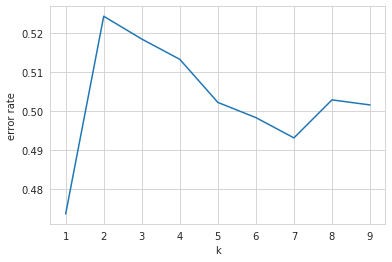

In [253]:
# Now find the best k on the validation set
ks = list(range(1,10))
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, verbose=True)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])
plt.xlabel('k')
plt.ylabel('error rate')

In [254]:
# Now use the best k to compute the test error

best_K = 1

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K], verbose=True)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:800... Computing distances... Sorting... Computing predictions...Done
Processing batch 800:1000... Computing distances... Sorting... Computing predictions...Done
Processing batch 1000:1200... Computing distances... Sorting... Computing predictions...Done
Processing batch 1200:1400... Computing distances... Sorting... Computing predictions...Done
Processing batch 1400:1541... Computing distances... Sorting... Computing predictions...Done


When k=1 the test error rate is 47.6%%


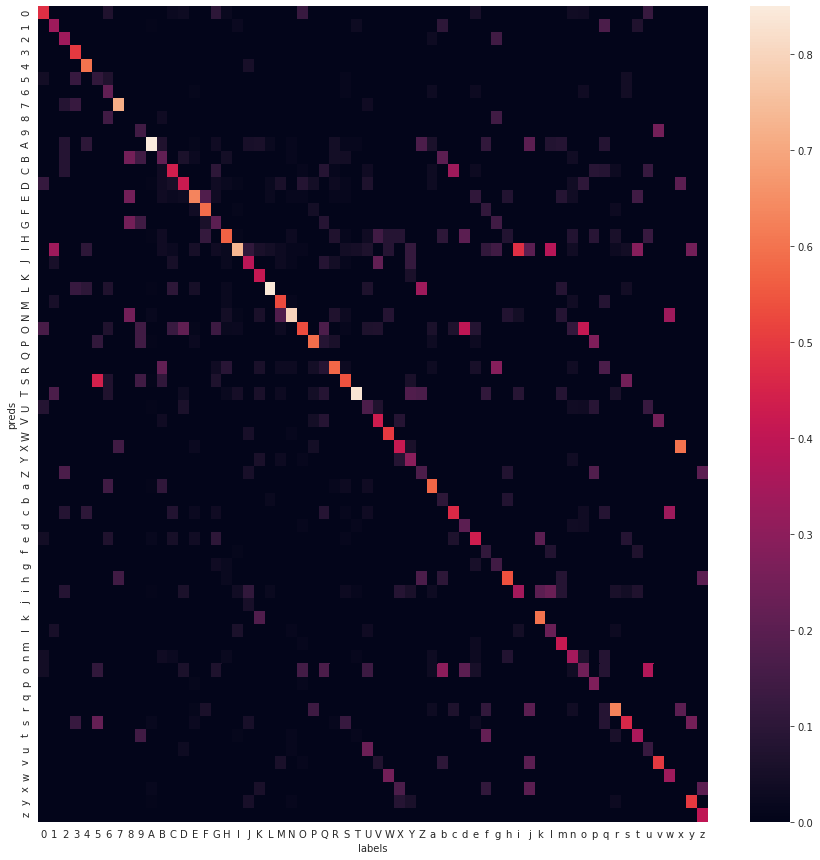

In [255]:
test_heatmap(mnist_test_preds, mnist_test_labels_int64)

# Edge detection

(96, 103, 3)
(96, 103)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'lw'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'lw'


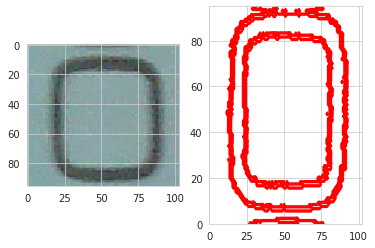

In [256]:
def detect_edges(im):
    thresh1 = 127

    #Get threashold mask for different regions
    gryim = np.mean(im[:,:,0:2],2)
    region1 =  (thresh1<gryim)
    nregion1 = ~ region1

    #Plot figure and two regions
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(im)

    #Get location of edge by comparing array to it's 
    #inverse shifted by a few pixels
    shift = -2
    edgex1 = (region1 ^ np.roll(nregion1,shift=shift,axis=0))
    edgey1 = (region1 ^ np.roll(nregion1,shift=shift,axis=1))

    #Plot location of edge over image
    axs[1].contour(edgex1,2,colors='r',lw=2.)
    axs[1].contour(edgey1,2,colors='r',lw=2.)
    plt.show()
    # print( type(edgex1), edgex1.shape, type(im), im.shape )
    # return edgex1+edgex1


files = ['English/Img/GoodImg/Bmp/Sample001/img001-00001.png',
         'English/Img/GoodImg/Bmp/Sample001/img001-00002.png',
         'English/Img/GoodImg/Bmp/Sample001/img001-00003.png',
         'English/Img/GoodImg/Bmp/Sample001/img001-00004.png',
         'English/Img/GoodImg/Bmp/Sample001/img001-00005.png']


for i in range(1):
    im = imageio.imread(files[i])
    print( im.shape )
    print( np.mean(im[:,:,0:2],2).shape )
    # img = Image.open(files[i])
    # new_img = img.resize((28,28))
    # im = np.array(new_img)

    res = detect_edges(im)
    # print( 'NEW', im.shape, res.shape)

In [0]:
def load_color_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        new_img = img.resize((28,28))
        np_img = np.array(new_img)
        images.append(np_img)
    return images

def load_color_folders_from_folder(folder):
    images = []
    filenames = os.listdir(folder)
    filenames.sort()
    for filename in filenames:
        images.append(load_color_images_from_folder(os.path.join(folder,filename)))
    return images

In [0]:
images = load_folders_from_folder('English/Img/GoodImg/Bmp/')

labels = get_labels()

# for i in [18,10]:
#     labels.pop(i)
#     images.pop(i)

list_labels = [[labels[i]] * len(images[i]) for i in range(len(labels))]

flat_list_images = [item for sublist in images for item in sublist]
flat_list_labels = [item for sublist in list_labels for item in sublist]


In [0]:
def detect_edges(im):
    thresh1 = 127

    #Get threashold mask for different regions
    # gryim = np.mean(im[:,:,0:2],2)
    gryim = im
    region1 =  (thresh1<gryim)
    nregion1 = ~ region1

    #Get location of edge by comparing array to it's 
    #inverse shifted by a few pixels
    shift = -2
    edgex1 = (region1 ^ np.roll(nregion1,shift=shift,axis=0))
    edgey1 = (region1 ^ np.roll(nregion1,shift=shift,axis=1))

    return edgex1+edgex1

In [0]:
length = len(flat_list_images)

for i in range(length):
    old = flat_list_images[i]
    new = detect_edges(flat_list_images[i])
    # print( i, type(old), old.shape, type(new), new.shape )
    flat_list_images[i] = detect_edges(flat_list_images[i])

In [0]:
# shuffle data
flat_list_images, flat_list_labels = shuffle_two(flat_list_images, flat_list_labels)

In [0]:
# Split train data into train and validation sets
flat_list_images = np.asarray(flat_list_images)
flat_list_labels = np.asarray(flat_list_labels)

test = int(flat_list_images.shape[0]*0.9)
valid = int(flat_list_images.shape[0]*0.8)

mnist_full_train_data_uint8 = flat_list_images[:test]
mnist_full_train_labels_int64 = flat_list_labels[:test]
mnist_test_data_uint8 = flat_list_images[test:]
mnist_test_labels_int64 = flat_list_labels[test:]

mnist_train_data_uint8 = mnist_full_train_data_uint8[:valid]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:valid]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[valid:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[valid:]

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:770... Computing distances... Sorting... Computing predictions...Done


Text(0, 0.5, 'error rate')

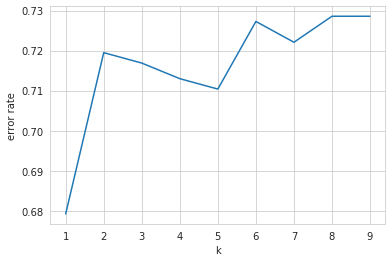

In [263]:
# Now find the best k on the validation set
ks = list(range(1,10))
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, verbose=True)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])
plt.xlabel('k')
plt.ylabel('error rate')

In [264]:
# Now use the best k to compute the test error

best_K = 1

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K], verbose=True)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:771... Computing distances... Sorting... Computing predictions...Done


When k=1 the test error rate is 66.0%%


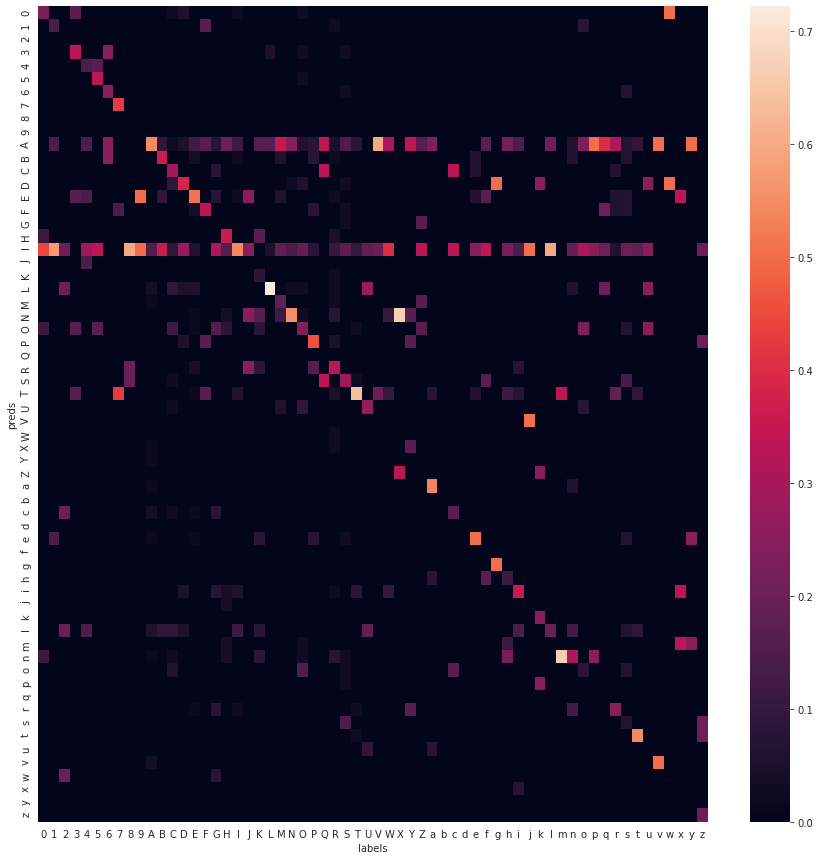

In [265]:
test_heatmap(mnist_test_preds, mnist_test_labels_int64)

## Edge detection with smaller label set

In [0]:
images = load_folders_from_folder('English/Img/GoodImg/Bmp/')

labels = get_labels()

# for i in [28,18,10]:
for i in [18]:
    labels.pop(i)
    images.pop(i)

list_labels = [[labels[i]] * len(images[i]) for i in range(len(labels))]

flat_list_images = [item for sublist in images for item in sublist]
flat_list_labels = [item for sublist in list_labels for item in sublist]


In [0]:
length = len(flat_list_images)

for i in range(length):#[7087,7088,7089]:
    old = flat_list_images[i]
    new = detect_edges(flat_list_images[i])
    # print( i, type(old), old.shape, type(new), new.shape )
    flat_list_images[i] = detect_edges(flat_list_images[i])

In [0]:
# shuffle data
flat_list_images, flat_list_labels = shuffle_two(flat_list_images, flat_list_labels)

In [0]:
# Split train data into train and validation sets
flat_list_images = np.asarray(flat_list_images)
flat_list_labels = np.asarray(flat_list_labels)

test = int(flat_list_images.shape[0]*0.9)
valid = int(flat_list_images.shape[0]*0.8)

mnist_full_train_data_uint8 = flat_list_images[:test]
mnist_full_train_labels_int64 = flat_list_labels[:test]
mnist_test_data_uint8 = flat_list_images[test:]
mnist_test_labels_int64 = flat_list_labels[test:]

mnist_train_data_uint8 = mnist_full_train_data_uint8[:valid]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:valid]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[valid:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[valid:]

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:740... Computing distances... Sorting... Computing predictions...Done


Text(0, 0.5, 'error rate')

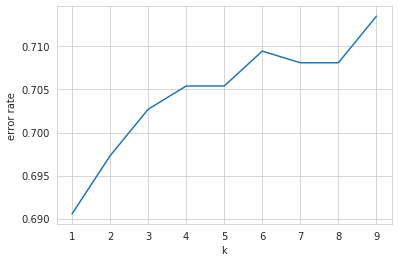

In [271]:
# Now find the best k on the validation set
ks = list(range(1,10))
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, verbose=True)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])
plt.xlabel('k')
plt.ylabel('error rate')

In [272]:
# Now use the best k to compute the test error

best_K = 1

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K], verbose=True)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:741... Computing distances... Sorting... Computing predictions...Done


When k=1 the test error rate is 67.1%%


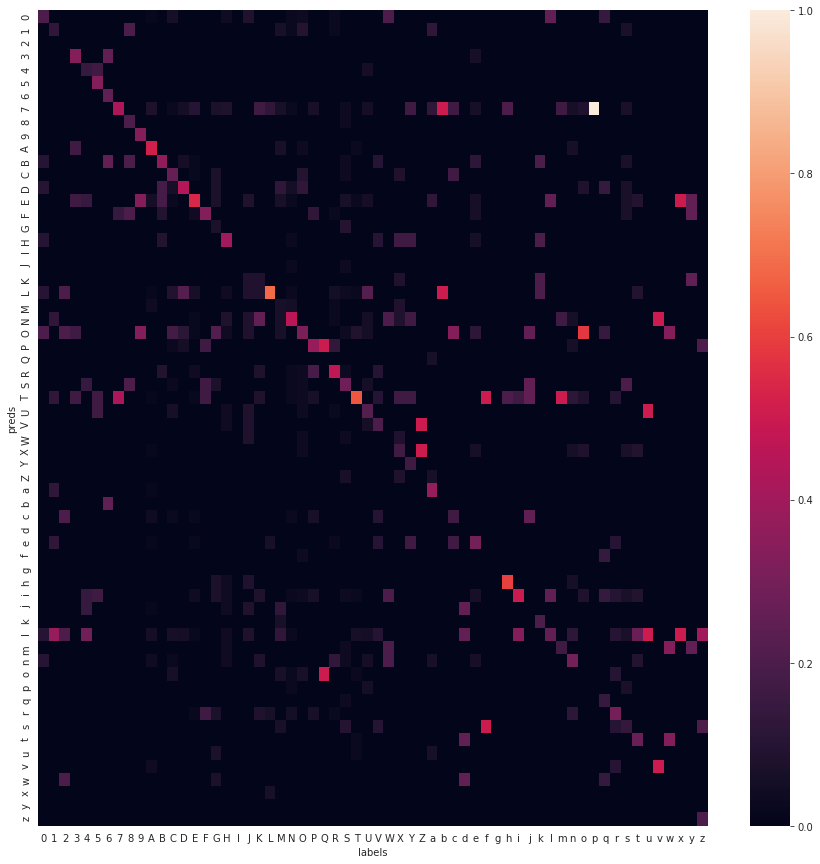

In [273]:
test_heatmap(mnist_test_preds, mnist_test_labels_int64)

# Neural Networks

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Fastai library
from fastai.vision import *
from fastai.metrics import error_rate

**Batch size** is the number of training images to be fed to the model at once. 

In [0]:
bs = 64

In [0]:
np.random.seed(2)

## Dataset preprocessing

In [0]:
![ -e EnglishNames ] || mkdir EnglishNames

In [164]:
!ls

English		EnglishNames  n_msk_error.png  t_error.png
EnglishImg.tgz	n_error.png   sample_data      t_msk_error.png


In [0]:
from shutil import copyfile

def copy_images(folder, destination):
    images = []
    for filename in os.listdir(folder):
        src = os.path.join(folder,filename)
        pat = r'(\d+)(?!.*\d)'
        pattern=re.compile(pat)
        result=pattern.findall(filename)
        dst = destination+'_'+result[0]+'.png'
        copyfile(src, dst)
        # print( src, dst )

def copy_folders(folder, destination):
    images = []
    labels = get_labels()
    filenames = os.listdir(folder)
    filenames.sort()
    for i in range(len(filenames)):
        src = os.path.join(folder,filenames[i])
        dst = os.path.join(destination, str(labels[i]))
        copy_images(src,dst)

copy_folders('English/Img/GoodImg/Bmp/', 'EnglishNames/' )

In [166]:
!ls 'EnglishNames/'

0_00001.png  A_00535.png  E_00367.png  l_00001.png  O_00174.png  S_00153.png
0_00002.png  A_00536.png  E_00368.png  L_00001.png  O_00175.png  S_00154.png
0_00003.png  A_00537.png  E_00369.png  l_00002.png  O_00176.png  S_00155.png
0_00004.png  A_00538.png  E_00370.png  L_00002.png  O_00177.png  S_00156.png
0_00005.png  A_00539.png  E_00371.png  l_00003.png  O_00178.png  S_00157.png
0_00006.png  A_00540.png  E_00372.png  L_00003.png  O_00179.png  S_00158.png
0_00007.png  A_00541.png  E_00373.png  l_00004.png  O_00180.png  S_00159.png
0_00008.png  A_00542.png  E_00374.png  L_00004.png  O_00181.png  S_00160.png
0_00009.png  A_00543.png  E_00375.png  l_00005.png  O_00182.png  S_00161.png
0_00010.png  A_00544.png  E_00376.png  L_00005.png  O_00183.png  S_00162.png
0_00011.png  A_00545.png  E_00377.png  l_00006.png  O_00184.png  S_00163.png
0_00012.png  A_00546.png  E_00378.png  L_00006.png  O_00185.png  S_00164.png
0_00013.png  A_00547.png  E_00379.png  l_00007.png  O_00186.png  S_00165.png

In [0]:
path_img = 'EnglishNames/'
fnames = get_image_files(path_img)

In [168]:
fnames[1] #An instance from the list fnames, which contains the path of an image

PosixPath('EnglishNames/f_00004.png')

In [0]:
pat = r'/([^/]+)_\d+.png$'

**ImageDataBunch** is a class that creates a training dataset, *train_ds*, and a validation dataset, *valid_ds*.

**from_name_re** gets the labels from the list of file names, *fnames*, using a regular expression. The regular expression is obtained after compiling the expression pattern *pat*.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

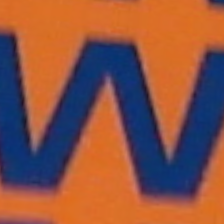

In [171]:
data.train_ds[600][0]


In [172]:
print (len(data.train_ds)) #Total Training Images
print (len(data.valid_ds)) #Total Validation Images

6164
1540


In [173]:
data.c #Total number of classes in our dataset


62

In [174]:
print( data.classes ) #Classes labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


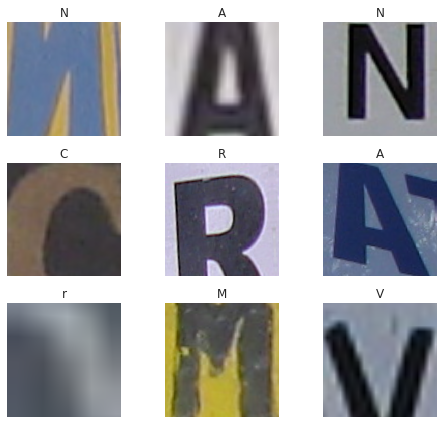

In [175]:
data.show_batch(rows=3, figsize=(7,6))


## Model Training

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)


In [177]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,error_rate,time
0,4.123706,2.582035,0.622727,01:14
1,2.847426,1.897568,0.507143,01:13
2,2.198436,1.589855,0.429221,01:13
3,1.841299,1.551192,0.418182,01:13


The accuracy achieved is (1 - error_rate) * 100%

In [0]:
learn.save('stage-1')


## Results interpretation

In [179]:
interp = ClassificationInterpretation.from_learner(learn)


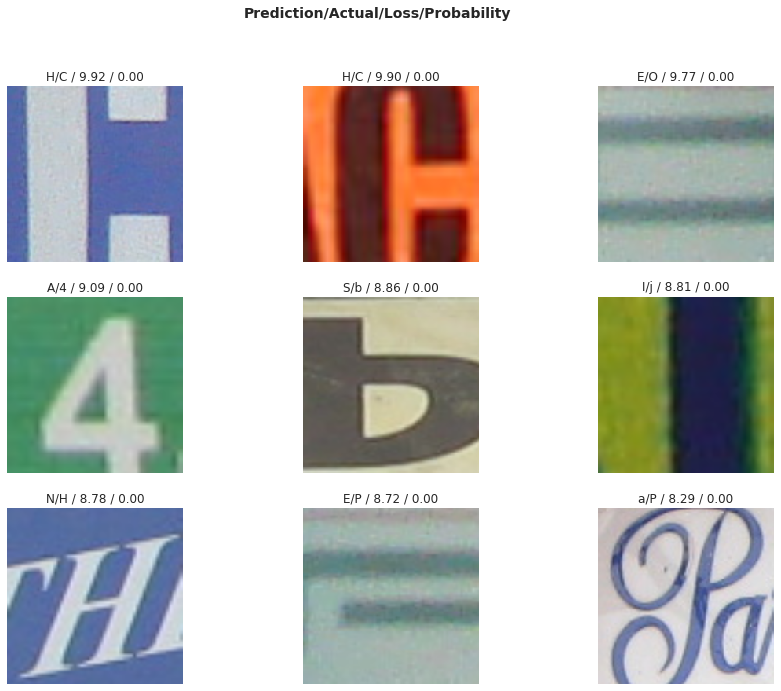

In [180]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

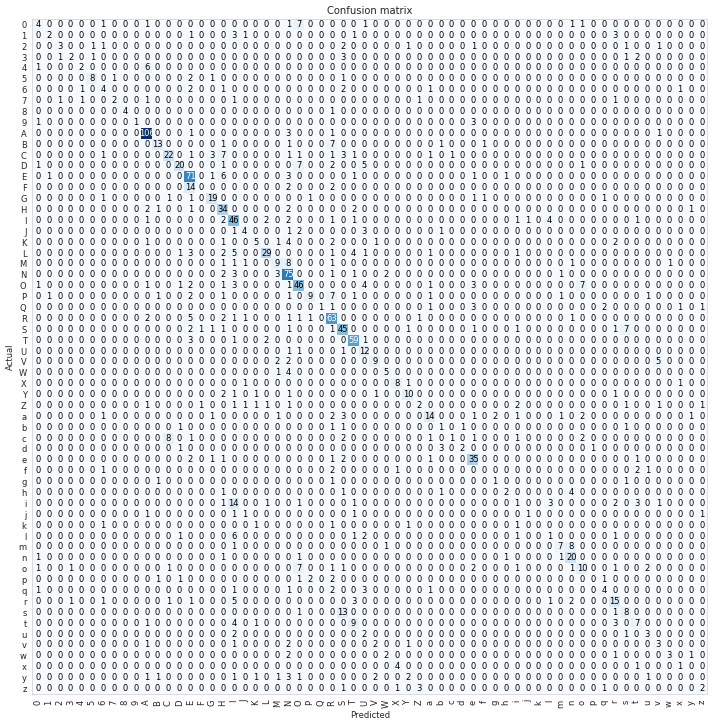

In [181]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [188]:
# error_rate verification
m = interp.confusion_matrix()
print( m.shape )
print( m.sum() )
print( np.trace(m) )
print( 1 - (np.trace(m) / m.sum()) )

(62, 62)
1540
896
0.4181818181818182


In [182]:
interp.most_confused(min_val=2)
# (predicted, actual, number of examples)

[('F', 'E', 14),
 ('i', 'I', 14),
 ('s', 'S', 13),
 ('t', 'T', 9),
 ('M', 'N', 8),
 ('c', 'C', 8),
 ('m', 'n', 8),
 ('0', 'O', 7),
 ('B', 'R', 7),
 ('C', 'H', 7),
 ('D', 'O', 7),
 ('O', 'o', 7),
 ('P', 'R', 7),
 ('S', 's', 7),
 ('o', 'O', 7),
 ('4', 'A', 6),
 ('E', 'H', 6),
 ('l', 'I', 6),
 ('D', 'U', 5),
 ('L', 'I', 5),
 ('R', 'E', 5),
 ('V', 'v', 5),
 ('r', 'I', 5),
 ('I', 'l', 4),
 ('K', 'N', 4),
 ('L', 'T', 4),
 ('O', 'U', 4),
 ('W', 'N', 4),
 ('h', 'n', 4),
 ('t', 'I', 4),
 ('x', 'X', 4),
 ('1', 'I', 3),
 ('1', 'r', 3),
 ('3', 'S', 3),
 ('9', 'e', 3),
 ('A', 'N', 3),
 ('C', 'G', 3),
 ('C', 'S', 3),
 ('E', 'N', 3),
 ('J', 'U', 3),
 ('L', 'E', 3),
 ('N', 'I', 3),
 ('N', 'M', 3),
 ('O', 'I', 3),
 ('O', 'e', 3),
 ('Q', 'e', 3),
 ('T', 'E', 3),
 ('a', 'S', 3),
 ('d', 'b', 3),
 ('i', 'l', 3),
 ('i', 't', 3),
 ('q', 'U', 3),
 ('r', 'T', 3),
 ('t', 'r', 3),
 ('y', 'N', 3),
 ('z', 'Z', 3),
 ('2', 'S', 2),
 ('3', 't', 2),
 ('5', 'E', 2),
 ('6', 'E', 2),
 ('6', 'S', 2),
 ('D', 'R', 2),
 ('F'

## Freezing and Unfreezing

**Layers:**

- Conv - convolution is simply an element-wise multiplication of two matrices followed by a sum

- BatchNorm - batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.

- ReLu - returns maximum of zero, and iput data with some gaussian noise

- MaxPool - rerurn maximum value from input set

- Flatten - literally flatten 2d feature map into a column

- Dropout - some number of layer outputs are randomly ignored or “dropped out” 

- Linear - output the full range of values of the target variable

In [158]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [103]:
learn.unfreeze()
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.661387,1.156013,0.320779,01:17
1,1.182084,0.797119,0.231818,01:17


## Fine-Tuning

In [0]:
learn.load('stage-1');

In [105]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


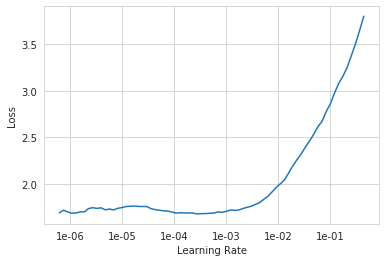

In [106]:
learn.recorder.plot()

In [107]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.660136,1.426201,0.388312,01:17
1,1.564713,1.385208,0.370130,01:18


In [108]:
learn.load('stage-1');
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.642243,1.281096,0.348701,01:18
1,1.375502,1.167994,0.325974,01:18


In [109]:
learn.load('stage-1');
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.542831,1.128129,0.322727,01:18
1,1.184980,0.946484,0.267532,01:18


In [110]:
learn.load('stage-1');
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.567372,1.071050,0.311039,01:18
1,1.101359,0.818051,0.243506,01:18


In [116]:
print( "%f" % (1e-4) )
print( "%f" % (5e-3) )
print( "%f" % (1e-3) )

0.000100
0.005000
0.001000


In [117]:
learn.load('stage-1');
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,4e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.870151,1.293366,0.346753,01:17
1,1.201004,0.794368,0.227922,01:18


In [118]:
learn.load('stage-1');
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(2e-3,4e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.168087,1.716561,0.460390,01:18
1,1.459977,0.932347,0.280519,01:19


In [119]:
learn.load('stage-1');
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-3,4e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.953174,1.644027,0.433117,01:19
1,1.381761,0.866738,0.255195,01:18


In [120]:
learn.load('stage-1');
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(5e-4,4e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.901288,1.420020,0.371429,01:18
1,1.300154,0.840075,0.252597,01:18


## Bigger Neural Network

In [132]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [133]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.874387,2.569654,0.603247,01:25
1,2.645359,1.760043,0.455195,01:24
2,1.934471,1.398659,0.382468,01:25
3,1.543314,1.333323,0.359740,01:25
